In [1]:
%load_ext autoreload
%autoreload 2

import math
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from pathlib import Path
from context import LocalLearning
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt
import os
import copy
from scipy import stats

plt.style.use(['seaborn-paper', "./PRLDoubleCol.mplstyle"])

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Cuda available, choose device: {device}")
else:
    device = torch.device('cpu')
    print(f"Cuda unavailable, choose device: {device}")

Cuda available, choose device: cuda


In [4]:
BATCH_SIZE = 1000
NUMBER_OF_EPOCHS = 300

params = {
        "in_size": 28**2,# MNIST configuration
        "hidden_size": 2000,
        "n": 1.0,
        "p": 3.0,
        "no_classes": 10,
}

In [5]:
train_data = LocalLearning.LpUnitMNIST(
    root="../data/MNIST",
    train=True,
    p=params["p"],
)

dataloader_train = LocalLearning.DeviceDataLoader(
    train_data,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True,
)

test_data = LocalLearning.LpUnitMNIST(
    root="../data/MNIST",
    train=False,
    p=params["p"],
)

dataloader_test = LocalLearning.DeviceDataLoader(
    test_data,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
)

/storA/LocalLearning/LocalLearning/src/LocalLearning/LocalLearning.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.dataset.targets = torch.tensor(self.dataset.targets)


In [6]:
def train(
    trainSet: DataLoader,
    testSet: DataLoader,
    model: LocalLearning.KHModel, 
    loss_fn,
    optimizer,
    learning_rate=None,
    no_epochs=1000,
    checkpt_period=None,
    device=torch.device('cpu'),
    ):
    
    # for scheduling, the learning rate can be a function of the epoch
    if type(learning_rate).__name__ != "function":
        if type(learning_rate).__name__ == "NoneType":
            learning_rate = 1e-3
            
        lr = lambda epoch: learning_rate
        
    else:
        lr = learning_rate
    
    loss_history = [] # loss in each epoch
    score_history = [] # accuracy score in each epoch
    
    with tqdm(range(1, no_epochs + 1), unit="epoch") as tepoch:
        tepoch.set_description(f"Training time [epochs]")
        
        for epoch in tepoch:
            # adjust the learning rate
            optimizer.param_groups[0]['lr'] = lr(epoch)
            
            cumm_loss = 0.0
            model.train()
            for batch_no, (features, labels) in enumerate(trainSet):
                preds, _ = model(features.to(device))
                loss = loss_fn(preds, labels)
                cumm_loss += loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
            loss_history.append(cumm_loss)
            
            freq_correct = 0
            model.eval()
            for batch_no, (features, labels) in enumerate(testSet):
                preds, _ = model(features)
                preds = torch.argmax(preds, dim=-1)
                freq_correct += (torch.abs(preds - labels) == 0).sum()
            
            score_history.append(freq_correct / (len(testSet)*testSet.batch_size))
            
    return torch.Tensor(loss_history), torch.Tensor(score_history)

In [7]:
model = LocalLearning.SHLP(params=params)
model.to(device)
model.train()

AdamOpt = Adam(model.parameters(), lr=1e-3)

def cross_entropy_loss(outputs, targets):
    # computationally stable
    log_probs = nn.functional.log_softmax(outputs, dim=-1)
    loss = (-log_probs.gather(1, targets[..., None])).sum() / len(outputs)
    
    # Compute negative log likelihood loss
    #loss = nn.functional.nll_loss(log_probs, targets)
    
    return loss

def khscheduleMNIST(epoch):
    if epoch <= 100:
        return 1e-3
    if (epoch <= 150)  and (epoch > 50):
        return 5e-4
    if (epoch <= 200) and (epoch > 60):
        return 1e-4
    if (epoch <= 250) and (epoch > 70):
        return 5e-5
    return 1e-5

loss_history, score_history = train(
    dataloader_train, 
    dataloader_test, 
    model, 
    cross_entropy_loss, 
    AdamOpt, 
    learning_rate=khscheduleMNIST, 
    no_epochs=NUMBER_OF_EPOCHS, 
    device=device,
)

  0%|          | 0/300 [00:00<?, ?epoch/s]

Text(0, 0.5, 'Accuracy(t)')

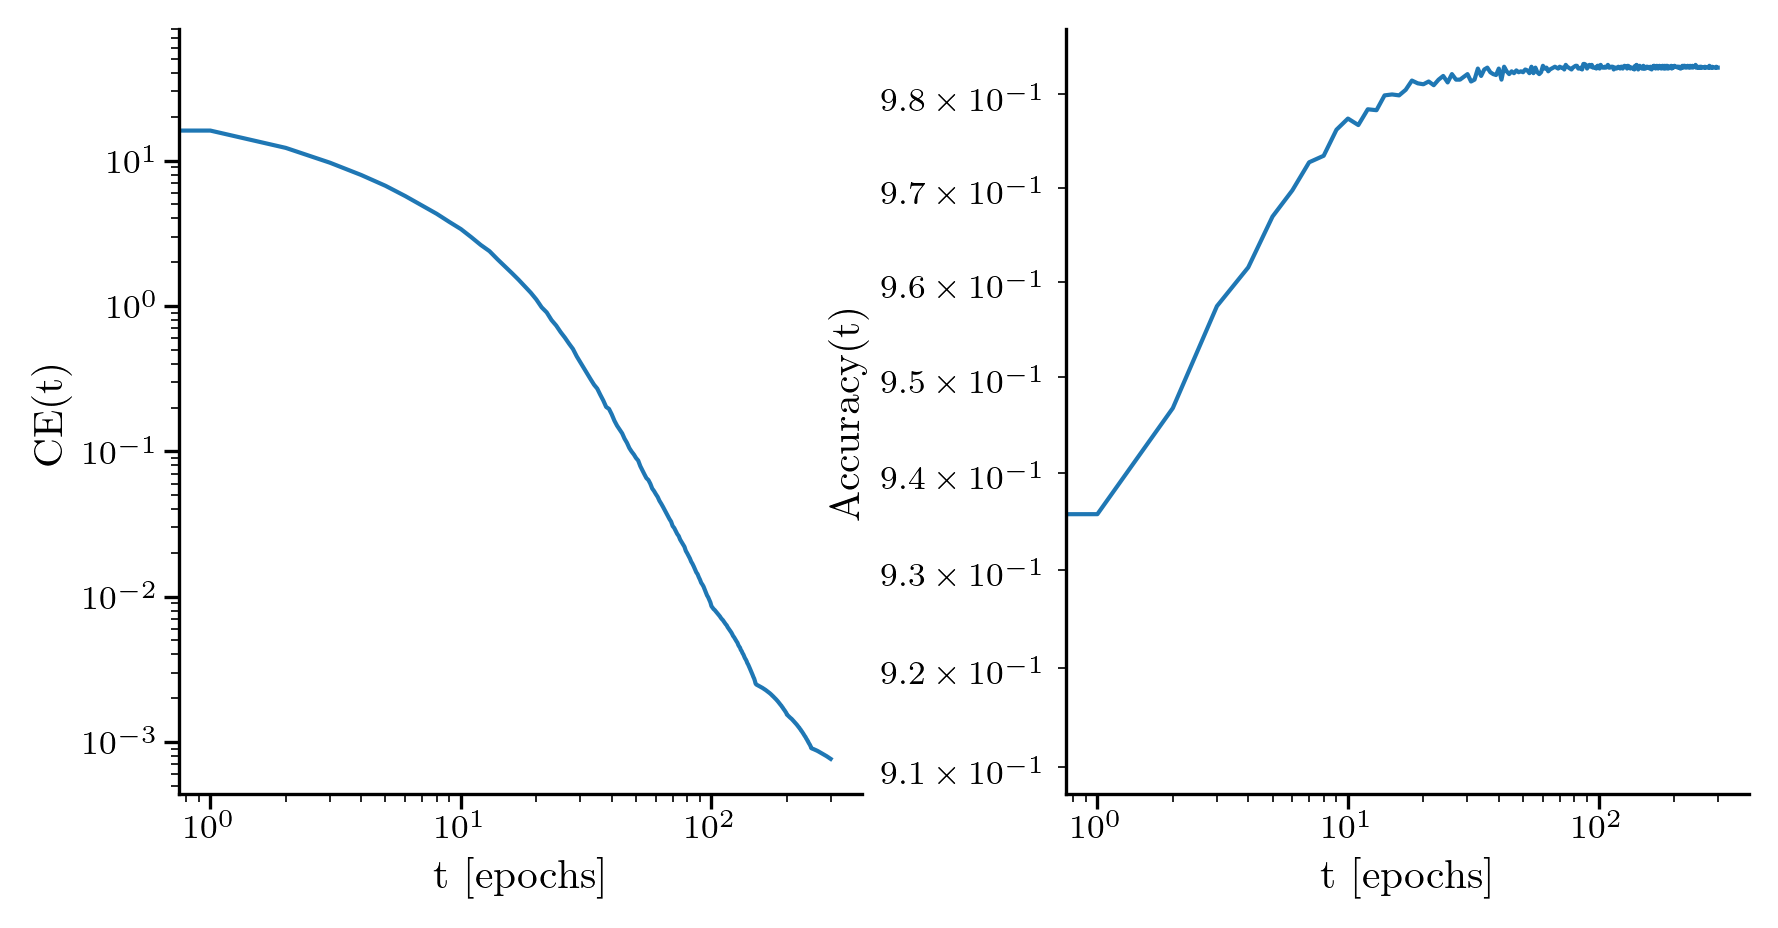

In [11]:
fig, axs = plt.subplots(1, 2)
loss_history_ann_cpu = np.array([a.cpu().detach().numpy() for a in loss_history])
accuracy_history_ann_cpu = np.array([a.cpu().detach().numpy() for a in score_history])
axs[0].loglog(loss_history_ann_cpu)
axs[0].set_xlabel(r"t [epochs]")
axs[0].set_ylabel(r"CE(t)")
axs[1].loglog(accuracy_history_ann_cpu)
axs[1].set_xlabel(r"t [epochs]")
axs[1].set_ylabel(r"Accuracy(t)")

# Local Learning Encodings and Weights

In [12]:
accuracy_history_ann_cpu[-1]

0.98289996